# Learning a CStree

In [96]:
import numpy as np
import networkx as nx

import cstrees.cstree as ct
import cstrees.stage as st
import cstrees.learning as ctl
import cstrees.scoring as sc

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Create the true CStree

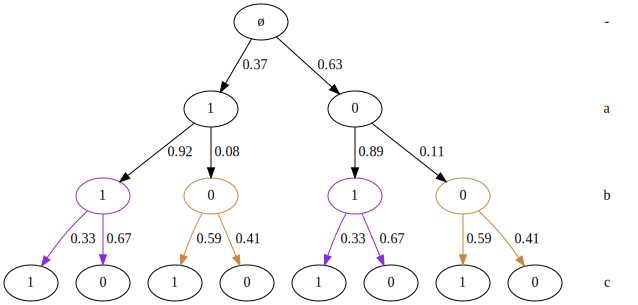

In [97]:
np.random.seed(5)
tree = ct.CStree([2] * 3, labels=["a", "b", "c"])

tree.update_stages({
    0: [st.Stage([0]), st.Stage([1])],
    1: [st.Stage([{0, 1}, 0]), st.Stage([{0, 1}, 1])]})

tree.sample_stage_parameters(alpha=1.0)
tree.plot()


context:  None


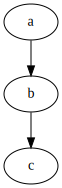

In [98]:
true_cdags = tree.to_minimal_context_graphs()
for key, val in true_cdags.items():
    print("context: ", key)
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
    agraph.draw("testing/"+str(key) + "_true.png",
                args='-Glabel="'+str(key)+'"   ')
agraph


## Draw a lot of samples

In [99]:
df = tree.sample(2000)
df

,a,b,c
0,2,2,2
1,1,1,1
2,0,0,1
3,1,1,0
4,0,1,0
...,...,...,...
1996,1,1,0
1997,0,1,1
1998,1,1,1
1999,1,1,0


# Calculate score tables

In [111]:
labels = list(df.columns)
print(labels)
poss_cvars = {l:list(set(labels) - {l}) for l in labels}
poss_cvars.update({"a":["b"]})
poss_cvars = None
print(poss_cvars)
score_table, context_scores, context_counts = sc.order_score_tables(df,
                                                                    max_cvars=2,
                                                                    poss_cvars=poss_cvars,
                                                                    alpha_tot=1.0,
                                                        method="BDeu")
import pp
pp(context_scores)
pp(score_table)

['a', 'b', 'c']
None


Context score tables:   0%|          | 0/3 [00:00<?, ?it/s]

Order score tables: 100%|██████████| 3/3 [00:00<00:00, 147.13it/s]

{
    'cards': {'a': 2, 'b': 2, 'c': 2},
    'scores': {
        'a': {
            'None': -1314.8372192470342,
            'b=0': -123.05442165335276,
            'b=0,c=0': -56.97978359212282,
            'b=0,c=1': -69.66712051290955,
            'b=1': -1189.5557724081164,
            'b=1,c=0': -801.7205839957328,
            'b=1,c=1': -392.20684932179915,
            'c=0': -856.3577776791244,
            'c=1': -462.726408189985,
        },
        'b': {
            'None': -675.8909346581898,
            'a=0': -477.6140279924447,
            'a=0,c=0': -234.69494341569376,
            'a=0,c=1': -227.57283986922857,
            'a=1': -196.04988148018006,
            'a=1,c=0': -101.51065210465615,
            'a=1,c=1': -94.19171978087621,
            'c=0': -333.8630056116187,
            'c=1': -322.6169980053811,
        },
        'c': {
            'None': -1297.677178056911,
            'a=0': -826.268427475296,
            'a=0,b=0': -110.10459765001613,
           

## Find the optimal order by exhustive search

In [121]:
optord, score = ctl._find_optimal_order(score_table)
print("optimal order: {}, score {}".format(optord, score))

order: ['a', 'b', 'c'], score: -3271.189358854488
order: ['a', 'c', 'b'], score: -3272.202732186168
order: ['b', 'a', 'c'], score: -3271.189358854488
order: ['b', 'c', 'a'], score: -3271.1887783884054
order: ['c', 'a', 'b'], score: -3272.202732186168
order: ['c', 'b', 'a'], score: -3271.1887783884054
optimal order: ['b', 'c', 'a'], score -3271.1887783884054


## Find the optimal CStree (staging of each level) of the best order

In [122]:
opttree = ctl._optimal_cstree_given_order(optord, context_scores, max_cvars=2, poss_cvars=poss_cvars)
print("Optimal CStree stagings per level:")
for key, val in opttree.stages.items():
    if key == -1: continue
    print("level {}:".format(key))
    for val2 in val:
        print(val2)

order: ['b', 'c', 'a']

staging level: -1
var b (one level above)


TypeError: 'NoneType' object is not subscriptable

## Estimate the parameters

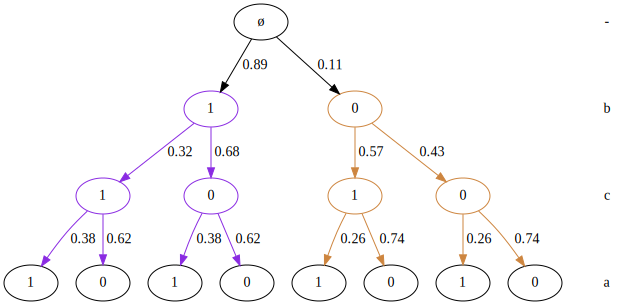

In [103]:
opttree.estimate_stage_parameters(df, alpha_tot=1.0, method="BDeu")
opttree.plot()


## Plot the minimal context DAGs

Context: None


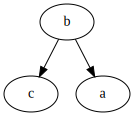

In [104]:
opt_cdags = opttree.to_minimal_context_graphs()
for key, val in opt_cdags.items():
    print("Context: {}".format(key))
    agraph = nx.nx_agraph.to_agraph(val)
    agraph.layout("dot")
agraph
